In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')


1 Physical GPUs, 1 Logical GPU


In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [5]:
data_dir = Path('/content/drive/MyDrive/dacon/input')
feature_dir = Path('../build/feature')
val_dir = Path('/content/drive/MyDrive/dacon/build/val')
tst_dir = Path('/content/drive/MyDrive/dacon/build/tst')
sub_dir = Path('/content/drive/MyDrive/dacon/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [6]:
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [35]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [36]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [37]:
train['text'] = train['text'].str.replace('\?',' quesmark ')
train['text'] = train['text'].str.replace('\!',' exclmark ')
train['text'] = train['text'].str.replace('\&',' empent ')
train['text'] = train['text'].str.replace("\*",' chstar ')
train['text'] = train['text'].str.replace(";",' smcolons  ')

test['text'] = test['text'].str.replace('\?',' quesmark ')
test['text'] = test['text'].str.replace('\!',' exclmark ')
test['text'] = test['text'].str.replace('\&',' empent ')
test['text'] = test['text'].str.replace("\*",' chstar ')
test['text'] = test['text'].str.replace(";",' smcolons  ')

In [38]:
cont_dict={"ain't": 'are not',
 "aren't": 'are not',
 "can't": 'can not',
 "can't've": 'can not have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "\'he'd": 'he would',
 "\'he'd've": 'he would have',
 "\'he'll": 'he will',
 "\'he'll've": 'he will have',
 "\'he's": 'he is',
 "\'how'd": 'how did',
 "\'how're": 'how are',
 "\'how'd'y": 'how do you',
 "\'how'll": 'how will',
 "\'how's": 'how is',
 "\'I'd": 'I would',
 "\'I'd've": 'I would have',
 "\'I'll": 'I will',
 "\'I'll've": 'I will have',
 "\'I'm": 'I am',
 "\'I've": 'I have',
 "\'he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how're": 'how are',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',         
 "isn't": 'is not',
 "\'it'd": 'it would',
 "\'it'd've": 'it would have',
 "\'it'll": 'it will',
 "\'it'll've": 'it will have',
 "\'it's": 'it is',
 "\'let's": 'let us',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "o'clock": 'of the clock',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "\'shan't": 'shall not',
 "\'sha'n't": 'shall not',
 "\'shan't've": 'shall not have',
 "\'she'd": 'she would',
 "\'she'd've": 'she would have',
 "\'she'll": 'she will',
 "\'she'll've": 'she will have',
 "\'she's": 'she is',
 "\'should've": 'should have',
 "\'shouldn't": 'should not',
 "\'shouldn't've": 'should not have',
 "shan't": 'shall not',
 "sha'n't": 'shall not',
 "shan't've": 'shall not have',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "she'll": 'she will',
 "she'll've": 'she will have',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',         
 "so've": 'so have',
 "so's": 'so is',
 "\'that'd": 'that would',
 "\'that'd've": 'that would have',
 "\'that's": 'that is',
 "\'there'd": 'there would',
 "\'there'd've": 'there would have',
 "\'there's": 'there is',
 "\'they'd": 'they would',
 "\'they'd've": 'they would have',
 "\'they'll": 'they will',
 "\'they'll've": 'they will have',
 "\'they're": 'they are',
 "\'they've": 'they have',
 "that'd": 'that would',
 "that'd've": 'that would have',
 "that's": 'that is',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "there's": 'there is',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they're": 'they are',
 "they've": 'they have',         
 "to've": 'to have',
 "wasn't": 'was not',
 "\'we'd": 'we would',
 "\'we'd've": 'we would have',
 "\'we'll": 'we will',
 "\'we'll've": 'we will have',
 "\'we're": 'we are',
 "\'we've": 'we have',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "\'what'll": 'what will',
 "\'what'll've": 'what will have',
 "\'what're": 'what are',
 "\'what's": 'what is',
 "\'what've": 'what have',
 "\'when's": 'when is',
 "\'when've": 'when have',
 "\'where'd": 'where did',
 "\'where's": 'where is',
 "\'where've": 'where have',
 "\'who'll": 'who will',
 "\'who'll've": 'who will have',
 "\'who's": 'who is',
 "\'who've": 'who have',
 "\'why's": 'why is',
 "\'why've": 'why have',
 "\'will've": 'will have',
 "\'won't": 'will not',
 "\'won't've": 'will not have',
 "\'would've": 'would have',
 "\'wouldn't": 'would not',
 "\'wouldn't've": 'would not have',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "when've": 'when have',
 "where'd": 'where did',
 "where's": 'where is',
 "where've": 'where have',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who's": 'who is',
 "who've": 'who have',
 "why's": 'why is',
 "why've": 'why have',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "\'you'd": 'you would',
 "\'you'd've": 'you would have',
 "\'you'll": 'you will',
 "\'you'll've": 'you shall have',
 "\'you're": 'you are',
 "\'you've": 'you have',
 "you'd": 'you would',
 "you'd've": 'you would have',
 "you'll": 'you will',
 "you'll've": 'you shall have',
 "you're": 'you are',
 "you've": 'you have',
 'jan.': 'january',
 'feb.': 'february',
 'mar.': 'march',
 'apr.': 'april',
 'jun.': 'june',
 'jul.': 'july',
 'aug.': 'august',
 'sep.': 'september',
 'oct.': 'october',
 'nov.': 'november',
 'dec.': 'december',
 'ain’t': 'are not',
 'aren’t': 'are not',
 'can’t': 'can not',
 'can’t’ve': 'can not have',
 '’cause': 'because',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'didn’t': 'did not',
 'doesn’t': 'does not',
 'don’t': 'do not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 '\'he’d': 'he would',
 '\'he’d’ve': 'he would have',
 '\'he’ll': 'he will',
 '\'he’ll’ve': 'he will have',
 '\'he’s': 'he is',
 '\'how’d': 'how did',
 '\'how’re': 'how are',
 '\'how’d’y': 'how do you',
 '\'how’ll': 'how will',
 '\'how’s': 'how is',
 '\'I’d': 'I would',
 '\'I’d’ve': 'I would have',
 '\'I’ll': 'I will',
 '\'I’ll’ve': 'I will have',
 '\'I’m': 'I am',
 '\'I’ve': 'I have',
 '\'isn’t': 'is not',
 '\'it’d': 'it would',
 '\'it’d’ve': 'it would have',
 '\'it’ll': 'it will',
 '\'it’ll’ve': 'it will have',
 '\'it’s': 'it is',
 '\'let’s': 'let us',  
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'she’ll': 'he will',
 'he’ll’ve': 'he will have',
 'odin’s' : 'odin is',
 'joe’s' : 'joe is',
 'dora’s' : 'dora is',
 'wickfield’s' : 'wickfield is',
 'tellson’s' : 'tellson is',
 'omer’s' :  'omer is',
 'cruncher’s' : 'crucher is', 
 'pip’s' : 'pip is',
 'creakle’s ': 'creakle is',
 'jorkins’s ' : 'jorkins is',
 'jane’s' : 'jane is',
 'elliot’s' : 'elliot is',
 'anne’s' : 'anne is',
 'tilney’s' : 'tilney is',
 'lizzy’s' : 'lizzy is',
 'smith’s' : 'smith is',
 'walter’s' : 'walter is',
 'musgrove’s' : 'musgrove is',
 'lucy’s' : 'lucy is',
 'nigel’s' : 'nigel is',
 'nay’s' : 'nay is',
 'chodinger’s' : 'chodinger is',
 'humphrey’s' : 'humphrey is',
 'jack’s' : 'jack is',
 'arthur’s': 'arthur is',
 'lana’s': 'lana is',
 'sarah’s': 'sarah is',
 'garcia’s' : 'garcia is',
 'ivan’s' : 'ivan is',
 'zossimov’s' : 'zossimov is',
 'totski’s' : 'totski is',
 'miusov’s' : 'miusov is',
 'rodya’s' : 'rodya is',
 'odin’s' : 'odin is',
 'maman’s' : 'maman is',
 'thee’s' : 'thee is',
 'ye’s' : 'ye is',
 'richard’s' : 'richard is',
 'silas’s' : 'silas is',
 'von’s': 'von is',
 'lanyon’s' : 'lanyon is',
 'jack’s' : 'jack is',
 'gunn’s' : 'gumn is',
 'nay’s' : 'nay is',  
 'rankeillor’s': 'rankeillor is',      
 'odin\'s' : 'odin is',
 'joe\'s' : 'joe is',
 'dora\'s' : 'dora is',
 'wickfield\'s' : 'wickfield is',
 'tellson\'s' : 'tellson is',
 'omer\'s' :  'omer is',
 'cruncher\'s' : 'crucher is', 
 'pip\'s' : 'pip is',
 'creakle\'s ': 'creakle is',
 'jorkins\'s ' : 'jorkins is',
 'jane\'s' : 'jane is',
 'elliot\'s' : 'elliot is',
 'anne\'s' : 'anne is',
 'tilney\'s' : 'tilney is',
 'lizzy\'s' : 'lizzy is',
 'smith\'s' : 'smith is',
 'walter\'s' : 'walter is',
 'musgrove\'s' : 'musgrove is',
 'lucy\'s' : 'lucy is',
 'nigel\'s' : 'nigel is',
 'nay\'s' : 'nay is',
 'chodinger\'s' : 'chodinger is',
 'humphrey\'s' : 'humphrey is',
 'jack\'s' : 'jack is',
 'arthur\'s': 'arthur is',
 'lana\'s': 'lana is',
 'sarah\'s': 'sarah is',
 'garcia\'s' : 'garcia is',
 'ivan\'s' : 'ivan is',
 'zossimov\'s' : 'zossimov is',
 'totski\'s' : 'totski is',
 'miusov\'s' : 'miusov is',
 'rodya\'s' : 'rodya is',
 'odin\'s' : 'odin is',
 'maman\'s' : 'maman is',
 'thee\'s' : 'thee is',
 'ye\'s' : 'ye is',
 'richard\'s' : 'richard is',
 'silas\'s' : 'silas is',
 'von\'s': 'von is',
 'lanyon\'s' : 'lanyon is',
 'jack\'s' : 'jack is',
 'gunn\'s' : 'gumn is',
 'nay\'s' : 'nay is',  
 'rankeillor\'s': 'rankeillor is',          
 '\'odin\'s' : 'odin is',
 '\'joe\'s' : 'joe is',
 '\'dora\'s' : 'dora is',
 '\'wickfield\'s' : 'wickfield is',
 '\'tellson\'s' : 'tellson is',
 '\'omer\'s' :  'omer is',
 '\'cruncher\'s' : 'crucher is', 
 '\'pip\'s' : 'pip is',
 '\'creakle\'s ': 'creakle is',
 '\'jorkins\'s ' : 'jorkins is',
 '\'jane\'s' : 'jane is',
 '\'elliot\'s' : 'elliot is',
 '\'anne\'s' : 'anne is',
 '\'tilney\'s' : 'tilney is',
 '\'lizzy\'s' : 'lizzy is',
 '\'smith\'s' : 'smith is',
 '\'walter\'s' : 'walter is',
 '\'musgrove\'s' : 'musgrove is',
 '\'lucy\'s' : 'lucy is',
 '\'nigel\'s' : 'nigel is',
 '\'nay\'s' : 'nay is',
 '\'chodinger\'s' : 'chodinger is',
 '\'humphrey\'s' : 'humphrey is',
 '\'jack\'s' : 'jack is',
 '\'arthur\'s': 'arthur is',
 '\'lana\'s': 'lana is',
 '\'sarah\'s': 'sarah is',
 '\'garcia\'s' : 'garcia is',
 '\'ivan\'s' : 'ivan is',
 '\'zossimov\'s' : 'zossimov is',
 '\'totski\'s' : 'totski is',
 '\'miusov\'s' : 'miusov is',
 '\'rodya\'s' : 'rodya is',
 '\'odin\'s' : 'odin is',
 '\'maman\'s' : 'maman is',
 '\'thee\'s' : 'thee is',
 '\'ye\'s' : 'ye is',
 '\'richard\'s' : 'richard is',
 '\'silas\'s' : 'silas is',
 '\'von\'s': 'von is',
 '\'lanyon\'s' : 'lanyon is',
 '\'jack\'s' : 'jack is',
 '\'gunn\'s' : 'gumn is',
 '\'nay\'s' : 'nay is',  
 '\'rankeillor\'s': 'rankeillor is',        
 'he’s': 'he is',
 'how’d': 'how did',
 'how’re': 'how are',
 'how’d’y': 'how do you',
 'how’ll': 'how will',
 'how’s': 'how is',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’m': 'I am',
 'I’ve': 'I have',
 'isn’t': 'is not',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’s': 'it is',
 'let’s': 'let us',          
 'ma’am': 'madam',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'o’clock': 'of the clock',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shan’t’ve': 'shall not have',
 '\'she’d': 'she would',
 '\'she’d’ve': 'she would have',
 '\'she’ll': 'she will',
 '\'she’ll’ve': 'she will have',
 '\'she’s': 'she is',
 '\'should’ve': 'should have',
 '\'shouldn’t': 'should not',
 '\'shouldn’t’ve': 'should not have',
 '\'so’ve': 'so have',
 '\'so’s': 'so is',
 '\'that’d': 'that would',
 '\'that’d’ve': 'that would have',
 '\'that’s': 'that is',
 '\'there’d': 'there would',
 '\'there’d’ve': 'there would have',
 '\'there’s': 'there is',
 '\'they’d': 'they would',
 '\'they’d’ve': 'they would have',
 '\'they’ll': 'they will',
 '\'they’ll’ve': 'they will have',
 '\'they’re': 'they are',
 '\'they’ve': 'they have',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'she’ll': 'she will',
 'she’ll’ve': 'she will have',
 'she’s': 'she is',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so is',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'that’s': 'that is',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'there’s': 'there is',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’re': 'they are',
 'they’ve': 'they have',      
 'to’ve': 'to have',
 'wasn’t': 'was not',
 '\'we’d': 'we would',
 '\'we’d’ve': 'we would have',
 '\'we’ll': 'we will',
 '\'we’ll’ve': 'we will have',
 '\'we’re': 'we are',
 '\'we’ve': 'we have',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’re': 'we are',
 'we’ve': 'we have',          
 'weren’t': 'were not',
 '\'what’ll': 'what will',
 '\'what’ll’ve': 'what will have',
 '\'what’re': 'what are',
 '\'what’s': 'what is',
 '\'what’ve': 'what have',
 '\'when’s': 'when is',
 '\'when’ve': 'when have',
 '\'where’d': 'where did',
 '\'where’s': 'where is',
 '\'where’ve': 'where have',
 '\'who’ll': 'who will',
 '\'who’ll’ve': 'who will have',
 '\'who’s': 'who is',
 '\'who’ve': 'who have',
 '\'why’s': 'why is',
 '\'why’ve': 'why have',
 '\'will’ve': 'will have',
 '\'won’t': 'will not',
 '\'won’t’ve': 'will not have',
 '\'would’ve': 'would have',
 '\'wouldn’t': 'would not',
 '\'wouldn’t’ve': 'would not have',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'what’re': 'what are',
 'what’s': 'what is',
 'what’ve': 'what have',
 'when’s': 'when is',
 'when’ve': 'when have',
 'where’d': 'where did',
 'where’s': 'where is',
 'where’ve': 'where have',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’s': 'who is',
 'who’ve': 'who have',
 'why’s': 'why is',
 'why’ve': 'why have',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',   
 'y’all': 'you all',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 '\'you’d': 'you would',
 '\'you’d’ve': 'you would have',
 '\'you’ll': 'you will',
 '\'you’ll’ve': 'you shall have',
 '\'you’re': 'you are',
 '\'you’ve': 'you have', 
 'you’d': 'you would',
 'you’d’ve': 'you would have',
 'you’ll': 'you will',
 'you’ll’ve': 'you shall have',
 'you’re': 'you are',
 'you’ve': 'you have'
}

In [39]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def clean_contraction(text):
    words = text_to_word_sequence(text)
    words=[cont_dict[word] if word in cont_dict else word for word in words]
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(clean_contraction)
test['text'] = test['text'].str.lower().apply(clean_contraction)

In [40]:
train['text']=train['text'].str.replace('\'s', '')
train['text']=train['text'].str.replace('’s', '')
train['text']=train['text'].str.replace("\'", '')
train['text']=train['text'].str.replace("’", '')

test['text']=test['text'].str.replace("’s",'')
test['text']=test['text'].str.replace("\'s",'')
test['text']=test['text'].str.replace("\'", '')
test['text']=test['text'].str.replace("’", '')


In [41]:
train['text']=train['text'].str.replace('á', '')
train['text']=train['text'].str.replace('ä', '')
train['text']=train['text'].str.replace('é', '')
train['text']=train['text'].str.replace('í', '')
train['text']=train['text'].str.replace('ó', '')
train['text']=train['text'].str.replace('ú', '')
train['text']=train['text'].str.replace('ý', '')
train['text']=train['text'].str.replace('ü', ' Umlaut ')

test['text']=test['text'].str.replace('ä', '')
test['text']=test['text'].str.replace('á', '')
test['text']=test['text'].str.replace('é', '')
test['text']=test['text'].str.replace('í', '')
test['text']=test['text'].str.replace('ó', '')
test['text']=test['text'].str.replace('ú', '')
test['text']=test['text'].str.replace('ý', '')
test['text']=test['text'].str.replace('ü', '')

In [42]:
def alpha_num(text):
    return re.sub(r'[0-9]', ' num ', text)

def remove_word(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in del_word:
            final_text.append(i.strip())
    return " ".join(final_text)


del_word = ['the', 'and' , 'to' , 'of' , 'a', 'was', 'in' , "about", "above", "after", "again", "against", "all","out", 
            "over", "own", "same", "those", "through", "to", "too", "under", "until", "up", "for", "further" ,"between", 
            "might","odin", "said", "one", "i", "man", "know", "see", "take", "come", "get", "nothing" , "something",
            "think", "find", "that", "was", "are", "yourself", "himself" , "myself"]

train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_word)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_word)

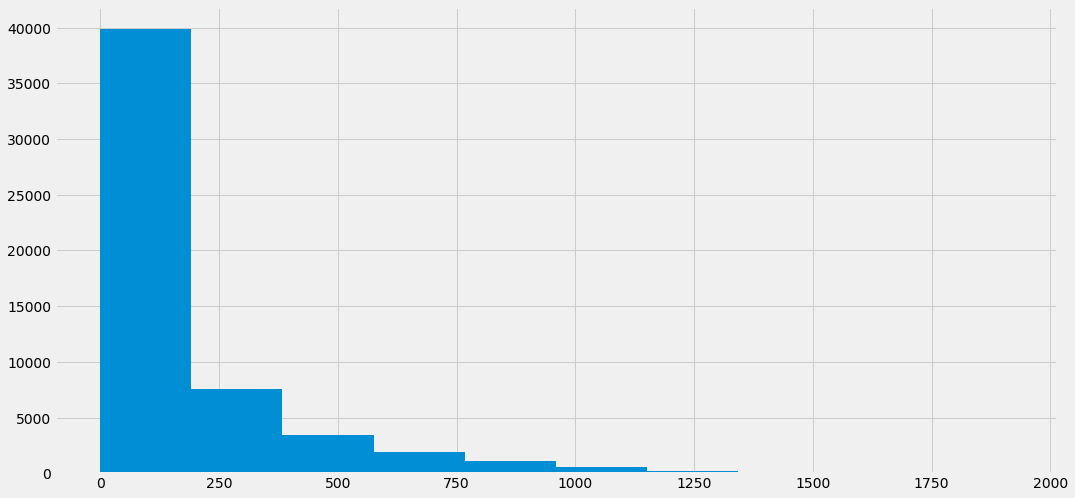

In [43]:
train['text'].str.len().hist()

In [44]:
X_trn = train['text'].values
X_tst = test['text'].values
y = train['author'].values
print(X_trn.shape, X_tst.shape, y.shape)

(54879,) (19617,) (54879,)


In [45]:
vocab_size = 20000
embedding_dim = 64
max_length = 330
padding_type='post'

In [46]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_trn)
word_index = tokenizer.word_index

In [47]:

train_sequences = tokenizer.texts_to_sequences(X_trn)
test_sequences = tokenizer.texts_to_sequences(X_tst)

In [48]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 250) (19617, 250)


In [49]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [50]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.2),
        Conv1D(256, 3, padding='valid', activation='relu', strides=1),   
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [51]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=256,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
172/172 [==============================] - 6s 34ms/step - loss: 1.0215 - val_loss: 0.7197
Epoch 2/10
172/172 [==============================] - 6s 32ms/step - loss: 0.5669 - val_loss: 0.6721
Epoch 3/10
172/172 [==============================] - 6s 32ms/step - loss: 0.3962 - val_loss: 0.7362
Epoch 4/10
172/172 [==============================] - 6s 32ms/step - loss: 0.3008 - val_loss: 0.8556
Epoch 5/10
172/172 [==============================] - 6s 32ms/step - loss: 0.2575 - val_loss: 0.9427
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
172/172 [==============================] - 6s 33ms/step - loss: 1.0517 - val_loss: 0.7178
Epoch 2/10
172/172 [==============================] - 6s 32ms/step - loss: 0.5956 - val_loss: 0.6693
Epoch 3/10
172/172 [==============================] - 6s 32ms/step - loss: 0.4168 - val_loss: 0.7115
Epoch 4/10
172/172 [==============================] - 5s 32ms/step - loss: 0.3310 - val_loss: 0.7783
Epoch 5/10
17

In [53]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')


Accuracy (CV):  75.6082%
Log Loss (CV):   0.6722


In [54]:

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [55]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [56]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0172,0.3711,5.7228e-01,0.0340,0.0053
1,0.1334,0.3667,2.5392e-02,0.2143,0.2602
2,0.9903,0.0084,8.8584e-05,0.0005,0.0007
3,0.1600,0.0146,6.2297e-01,0.0427,0.1597
4,0.5610,0.0317,2.3778e-02,0.2467,0.1368


In [57]:
sub.to_csv(sub_file)